In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import scipy
import itertools


In [2]:
def tau_effcal(dis_dens, bs, v0, Qs, Temp, ts, p, q, shear_strain_rate):
    #sub-function to calculate effective stress
    k_b = 1.381e-23
    thermal_var = -Temp*k_b/Qs
    ln_term = np.log(shear_strain_rate/(dis_dens*bs*v0))
    tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)
    return tau_eff

def fake_dislotwin(dis_dens, 
                   b_s, 
                   v_0, 
                   Q_s, 
                   T, 
                   tau_sol, 
                   p_s, q_s, 
                   e_s_1,
                   MFP,
                   Bulk_modulus,
                   h,
                   strain,
                   taylor_factor=3.06,
                   time_incs= 0.0001):
    #Sub function that calculates the shear stress for each given shear strain in a strain vector
    #effective stress is dependent on dislocation density, which increases over time depending on shear stress
    #Euler forward propagation is used. Variable names correspond to DAMASK paper
    shear_stress = 0
    strain /= taylor_factor
    #print(type(strain),strain)
    increments = int((strain/0.1)/time_incs)#int((strain/e_s_1)/time_incs)
    gamma_dot = e_s_1/taylor_factor
    rho = dis_dens
    for i in range(increments):
        tau_eff = tau_effcal(rho, b_s, v_0, Q_s, T, tau_sol, p_s, q_s, gamma_dot)
        shear_stress = tau_eff + Bulk_modulus * b_s * (rho * h)**0.5
        d_hat = Bulk_modulus*3*b_s/(16*3.14159*shear_stress)
        #print(gamma_dot, b_s,MFP)
        rho += time_incs*((gamma_dot/(b_s*MFP)) + (2*d_hat*rho*gamma_dot/b_s))
    return shear_stress*taylor_factor

def dislomodel(theta, strain_vector):
    #This function is for ease of use of the dislotwin function. variables are as per the DAMASK paper
    #except dis_dens is the dislocation density inital value, e_s_1 is the strain rate, and MFP is the
    #Dislocation mean free path that actually encapsulates other variables
    dis_dens, b_s, v_0, Q_s, T, tau_sol, p_s, q_s, e_s_1, MFP,h, Bulk_modulus = theta
    stress_vector = []
    for strain in strain_vector:
        stress_vector.append(fake_dislotwin(dis_dens, 
                   b_s, 
                   v_0, 
                   Q_s,  
                   T, 
                   tau_sol, 
                   p_s, q_s, 
                   e_s_1,
                   MFP,
                   Bulk_modulus,
                   h,
                   strain))
        #print(stress_vector)
        #print(strain_vector)
        #print(theta)
    return stress_vector

In [3]:
#Function that generates random values of input variables
def random_theta():
    dis_dens = 10**(np.random.uniform(low=6, high=8))
    b_s = 10**(-np.random.uniform(low=7.5, high=8.5))
    v_0 = 10**(np.random.uniform(low=0, high=2))
    Q_s = 10**(-np.random.uniform(low=18, high=20))
    T = 1323
    tau_sol = 10**(np.random.uniform(low=5, high=8))
    p_s = np.random.uniform(low=0.8, high=1)
    q_s = np.random.uniform(low=1.2, high=4)
    e_s_1 =0.1
    MFP = 10**(-np.random.uniform(low=0, high=5))
    h = 1
    Bulk_modulus = np.random.uniform(low=40e9, high=50e9)
    rand_theta = [dis_dens, b_s, v_0, Q_s, T, tau_sol, p_s, q_s, e_s_1, MFP, h, Bulk_modulus]
    return rand_theta,{'dis_dens':dis_dens, 
                       'b_s':b_s, 
                       'v_0':v_0, 
                       'Q_s':Q_s, 
                       'T':T, 
                       'tau_sol':tau_sol, 
                       'p_s':p_s,
                       'q_s':q_s, 
                       'e_s_1':e_s_1, 
                       'MFP':MFP, 
                       'h':h,
                       'Bulk_modulus':Bulk_modulus}

In [4]:
#data and noise for likelihood function
data = np.loadtxt('/Users/user/Documents/Monte_carlo/Dislotwin_mini_sim/luo_flat/e01s-1flat.csv',delimiter=',')
noise = 4e6

def likelihood(data_stress, model_stress, noise):
    return np.exp(-sum(((data_stress-model_stress)/(2*noise*len(data_stress)))**2))

/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)
/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)
/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)
/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)


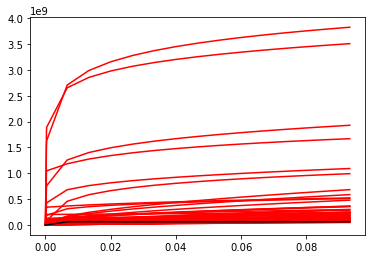

In [5]:
#generate random flow curves just to check model is behaving as expected
for i in range(100):
    plt.figure(2)
    case_theta, t = random_theta()
    plt.plot(data[:,0], dislomodel(case_theta, data[:,0]), color='r')
plt.plot(data[:,0], data[:,1], color='k')
# plt.ylim([0,1e10])

In [6]:
#generate no_tests numer of flow curves and calculate likelihoods.
values_tuple = ()
no_tests = 7000
ct, theta_dict = random_theta()
values_array = np.zeros([no_tests,len(ct)])
likelihood_weights = np.ones(no_tests) #likelihoods to be used as weights for each value
for i in range(no_tests):
    ct, theta_dict = random_theta()
    modelstress = dislomodel(ct, data[:,0])
    like = likelihood(data[:,1], modelstress, noise)
    if np.isnan(like):
        like = 0
    values_tuple = values_tuple + ((like, theta_dict),)
    values_array[i,:len(ct)] = ct[:]
    likelihood_weights[i] = like
    
#theta contains some constants. Remove constants from array so that covarience matrix can be calculated
values_array=np.delete(values_array,10,1)
values_array=np.delete(values_array,8,1)
values_array=np.delete(values_array,4, 1)
values_array=np.transpose(values_array)
np.shape(values_array)
#     if like > 0.01:
#         print(theta_dict, like)

/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/873222360.py:6: RuntimeWarning: invalid value encountered in double_scalars
  tau_eff = abs(ts *(1-(thermal_var*ln_term)**(1/p))**1/q)


(9, 7000)

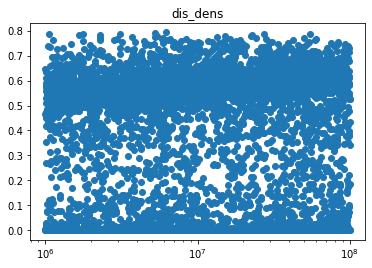

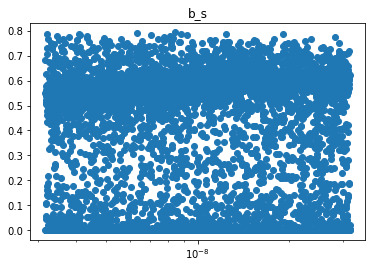

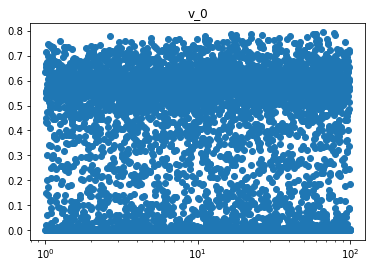

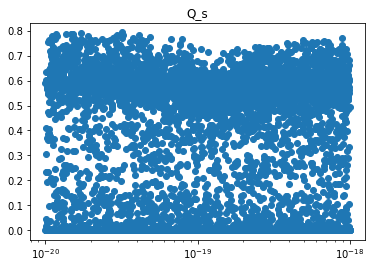

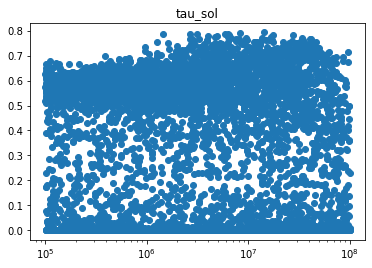

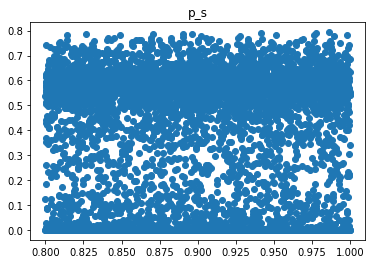

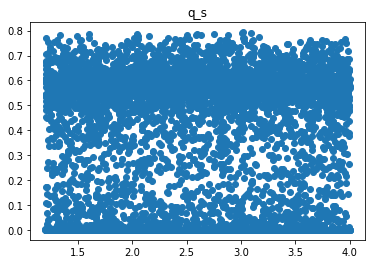

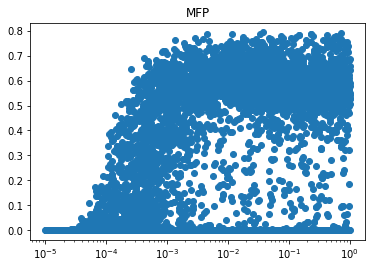

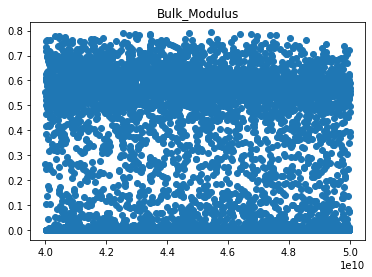

In [7]:
#Look at general shape of likelihood for individual values
keys = ['dis_dens',
                       'b_s',
                       'v_0',
                       'Q_s',
                       'tau_sol', 
                       'p_s',
                       'q_s', 
                       'MFP',
                       'Bulk_Modulus' ]
plt.figure(3)
plt.title(keys[0])
plt.xscale('log')
plt.scatter(values_array[0,:], likelihood_weights)
plt.figure(4)
plt.title(keys[1])
plt.xscale('log')
plt.scatter(values_array[1,:], likelihood_weights)
plt.figure(5)
plt.title(keys[2])
plt.xscale('log')
plt.scatter(values_array[2,:], likelihood_weights)
plt.figure(6)
plt.title(keys[3])
plt.xscale('log')
plt.scatter(values_array[3,:], likelihood_weights)
plt.figure(7)
plt.title(keys[4])
plt.xscale('log')
plt.scatter(values_array[4,:], likelihood_weights)
plt.figure(8)
plt.title(keys[5])
plt.xscale('linear')
plt.scatter(values_array[5,:], likelihood_weights)
plt.figure(9)
plt.title(keys[6])
plt.xscale('linear')
plt.scatter(values_array[6,:], likelihood_weights)
plt.figure(10)
plt.title(keys[7])
plt.xscale('log')
plt.scatter(values_array[7,:], likelihood_weights)
plt.figure(100)
plt.title(keys[8])
plt.xscale('linear')
plt.scatter(values_array[8,:], likelihood_weights)

In [8]:
#KDE estimation- not clear on advantages of different bandwith methods but theta values
kde = scipy.stats.gaussian_kde(values_array,  bw_method= 'scott',weights=likelihood_weights)
#find top 90th percentile of KDE values as boolean array
top_percentile = np.percentile(kde(values_array),90) < kde(values_array)
print(np.percentile(kde(values_array),95), max(kde(values_array)))

0.3058602508571594 0.5819675567284261


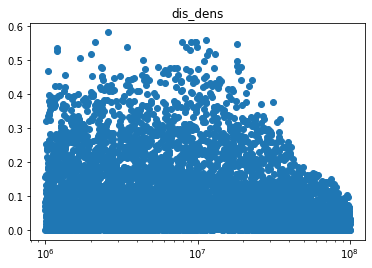

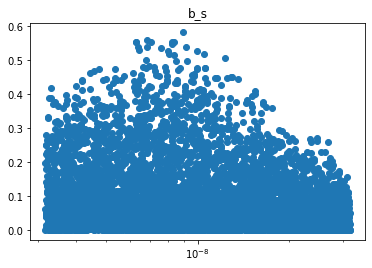

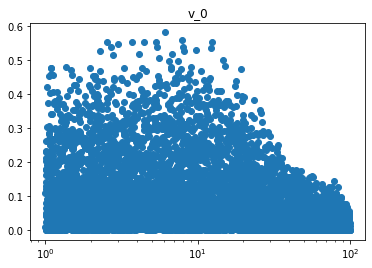

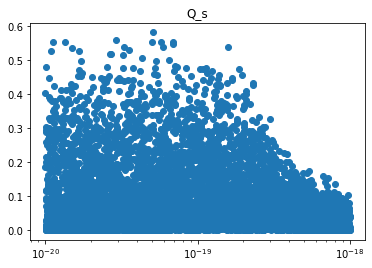

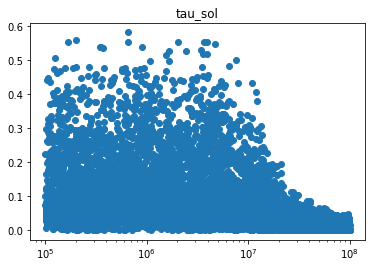

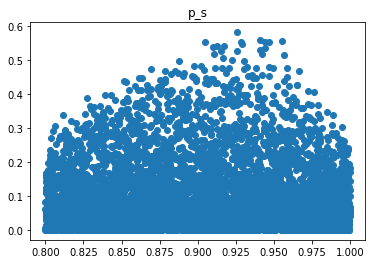

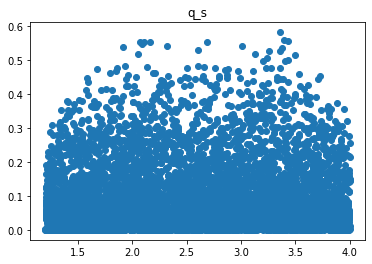

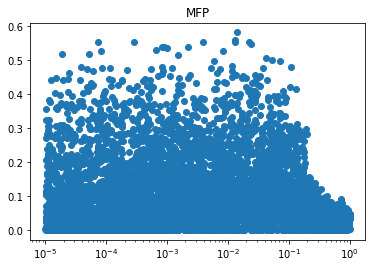

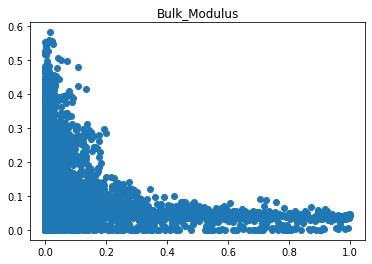

In [9]:
plt.figure(8)
plt.title(keys[0])
plt.xscale('log')
plt.scatter(values_array[0,:], kde(values_array))
plt.figure(9)
plt.title(keys[1])
plt.xscale('log')
plt.scatter(values_array[1,:], kde(values_array))
plt.figure(10)
plt.title(keys[2])
plt.xscale('log')
plt.scatter(values_array[2,:], kde(values_array))
plt.figure(11)
plt.title(keys[3])
plt.xscale('log')
plt.scatter(values_array[3,:], kde(values_array))
plt.figure(12)
plt.title(keys[4])
plt.xscale('log')
plt.scatter(values_array[4,:], kde(values_array))
plt.figure(13)
plt.title(keys[5])
plt.xscale('linear')
plt.scatter(values_array[5,:], kde(values_array))
plt.figure(14)
plt.title(keys[6])
plt.xscale('linear')
plt.scatter(values_array[6,:], kde(values_array))
plt.figure(15)
plt.title(keys[7])
plt.xscale('log')
plt.scatter(values_array[7,:], kde(values_array))
plt.figure(16)
plt.title(keys[8])
plt.xscale('linear')
plt.scatter(values_array[7,:], kde(values_array))

In [10]:
for i in range(len(keys)):
    max_val = max(values_array[i,top_percentile])
    min_val = min(values_array[i,top_percentile])
    print(keys[i], 'for high likelihood values is between min:', min_val, 
          'or 10**', np.log10(min_val), 'and max:', max_val, 'or 10**', np.log10(max_val))

cp_lik = 0
index_no = 0
for i in range(len(values_tuple)):
    if values_tuple[i][0] > cp_lik:
        cp_lik = values_tuple[i][0]
        cp_vals = values_tuple[i][1]
        index_no = i
print('max likelihood sample',cp_vals, 'row number:', index_no, values_array[:,index_no])
#closet set of values found by values_array[:,index_no])

dis_dens for high likelihood values is between min: 1011748.8745404657 or 10** 6.005072729958947 and max: 41399283.373191245 or 10** 7.61699282349379
b_s for high likelihood values is between min: 3.166768933990779e-09 or 10** -8.499383624141116 and max: 2.6870077016644875e-08 or 10** -7.570731088763856
v_0 for high likelihood values is between min: 1.0168127458417007 or 10** 0.0072409815015221654 and max: 33.70129933381757 or 10** 1.5276466451629998
Q_s for high likelihood values is between min: 1.0010509029808027e-20 or 10** -19.999543838283316 and max: 3.2251999418827695e-19 or 10** -18.491443356698554
tau_sol for high likelihood values is between min: 101014.22002868868 or 10** 5.004382514825103 and max: 13836179.842470882 or 10** 7.141016198332575
p_s for high likelihood values is between min: 0.8035058206253631 or 10** -0.09501097284423288 and max: 0.9961144301094713 or 10** -0.0016907684934436688
q_s for high likelihood values is between min: 1.2468898403963218 or 10** 0.0958280

In [11]:
#create axes for 2d plots
dis_dens = np.linspace(1e6, 1e8, num=100)
b_s = np.linspace(1e7, 1.3e8, num=100)
v_0 = np.linspace(1, 100, num=100)
Q_s = np.linspace(1e-20, 1.5e-19, num=100)
T = [1323]
tau_sol = np.linspace(1e5, 1e7, num=100)
p_s = [0.8,0.9,1]
q_s = np.linspace(1.2, 4, num=100)
e_s_1 =[0.1]
MFP = np.linspace(1, 1e5, num=100)
h = [1]
Bulk_modulus = np.linspace(40e9, 50e9, num=100)
big_tuple = np.array([dis_dens, b_s, v_0, Q_s, tau_sol, p_s, q_s, MFP, Bulk_modulus])

/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/4070936792.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  big_tuple = np.array([dis_dens, b_s, v_0, Q_s, tau_sol, p_s, q_s, MFP, Bulk_modulus])


In [12]:
#function to create a 2d plot for each pair of values. takes as input the KDE object, a list of the quantities
#so that only 2 values are being varies at a time. The keys, the axes and the values are kept in order so the 
#val indexes refer to the two values being compared. It also takes as input the meshgrid.
def contour2d_kde(kernel, standard_values_list, val_index1, val_index2, meshgrid):
    kernel_dens = np.zeros((np.shape(meshgrid)[1],np.shape(meshgrid)[2]))
    for i in range(np.shape(meshgrid)[1]):
        for j in range(np.shape(meshgrid)[2]):
            kde_input = standard_values_list
            kde_input[val_index1] = meshgrid[0][i][j]
            kde_input[val_index2] = meshgrid[1][i][j]
#             print(kde_input)
#             print(kernel(kde_input))
            kernel_dens[i,j] = kernel(kde_input)[0]
    return kernel_dens

/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/1506074662.py:8: UserWarning: No contour levels were found within the data range.
  plt.contour(mesh[0],mesh[1], kern)
/var/folders/pp/3cvdv_lx45x0qmbdmgb67cl40000gp/T/ipykernel_32150/1506074662.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figno)


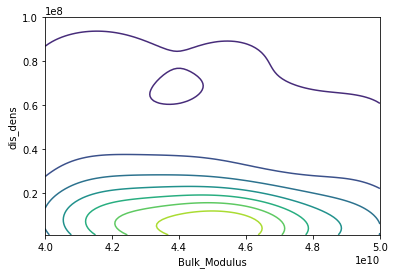

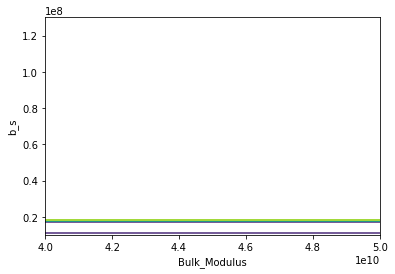

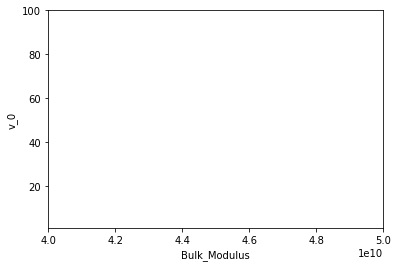

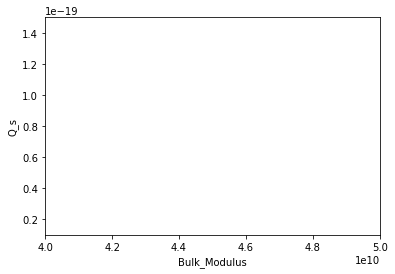

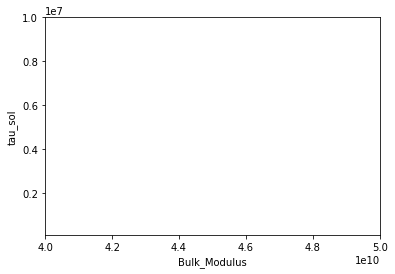

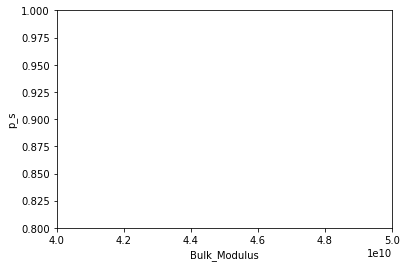

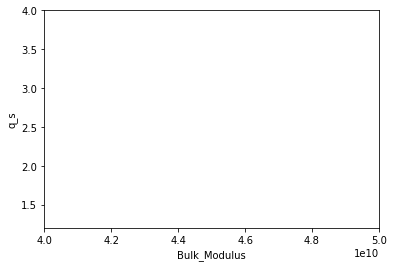

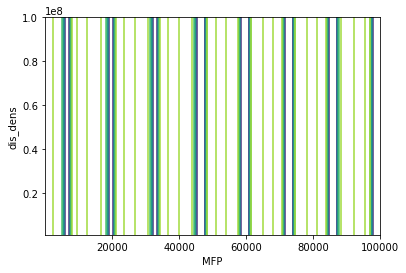

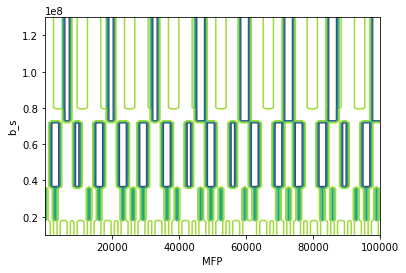

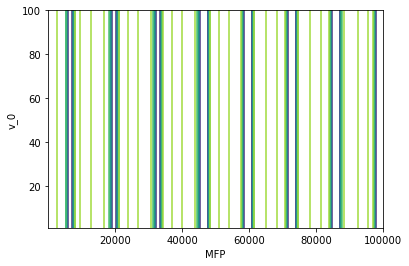

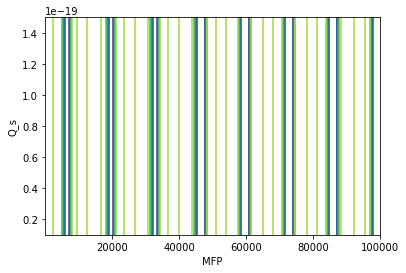

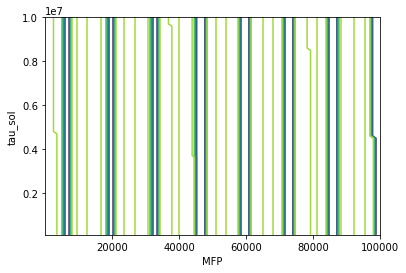

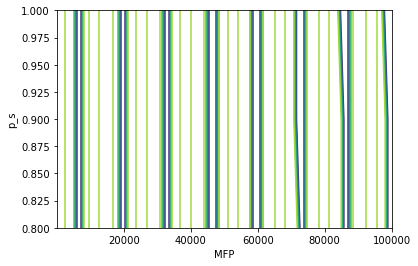

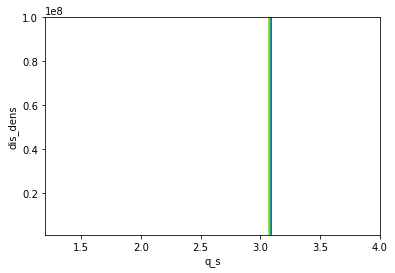

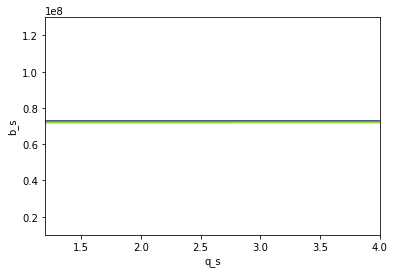

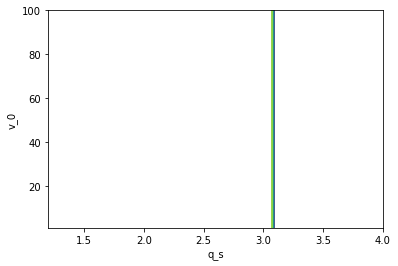

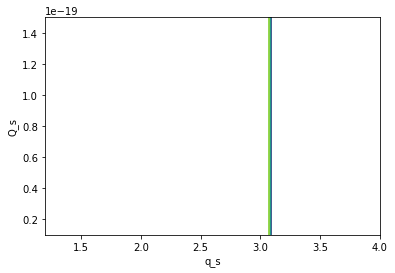

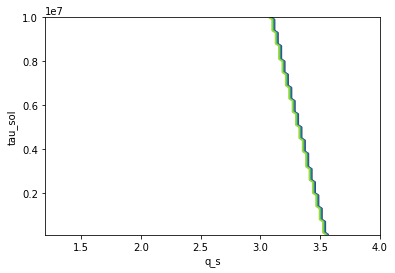

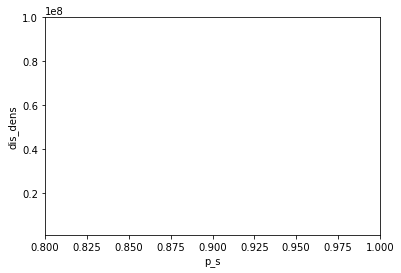

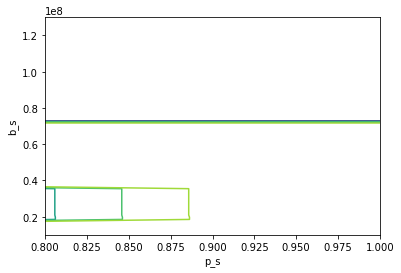

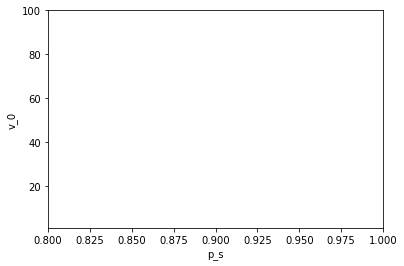

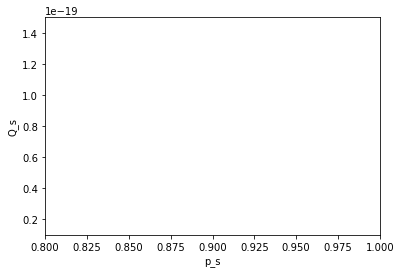

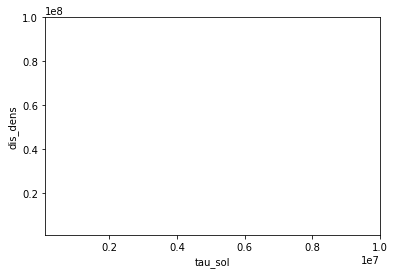

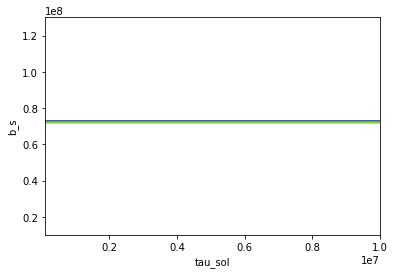

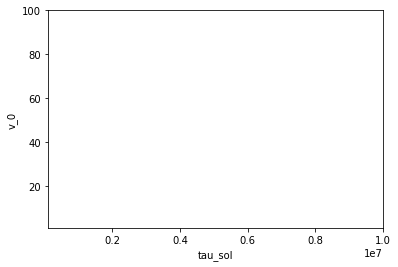

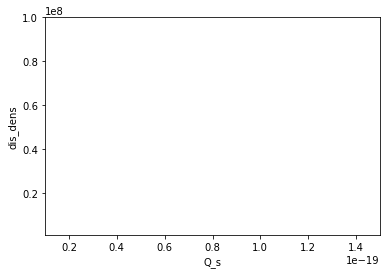

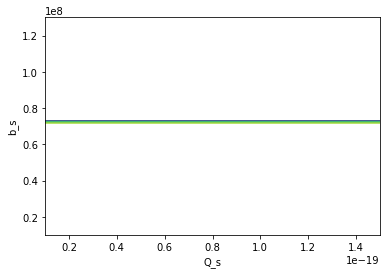

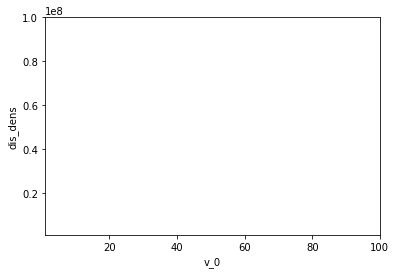

In [13]:
figno = 100
for i in range(len(keys)-1,-1,-1):
    for j in range(i-1):
        figno +=1
        mesh = np.meshgrid(big_tuple[i], big_tuple[j])
        kern = contour2d_kde(kde, values_array[:,index_no], i,j, mesh)
        plt.figure(figno)
        plt.contour(mesh[0],mesh[1], kern)
        plt.xlabel(keys[i])
        plt.ylabel(keys[j])